# 10. Memory retention

## 에방하우스의 망각곡선

![ebbinghaus](images/ebbinghaus.jpg)
출처 : http://enter367.tistory.com/75

The model assumes that the probability that an item will be remembered after a period of time t has elapsed is θt = exp (−αt)+β, with the restriction 0 < θt < 1. The α parameter corresponds to the rate of decay of information. The β parameter corresponds to a baseline level of remembering that is assumed to remain even after very long time periods.

In [1]:
t.var = seq(1,10, by = 1)

In [2]:
alpha = c(0, .1, .5, .9); beta = .2;
parameters = data.frame(alpha = alpha, beta = beta)

In [3]:
options(repr.plot.width = 5)
options(repr.plot.height = 5)

options(warn=-1) ## OFF 경고
suppressMessages(library(dplyr))

In [4]:
## 기억할 확률 = exp(-1*alpha*t.var)+beta
res.df = parameters %>% group_by(alpha) %>% do(res = exp(-1*.$alpha*t.var)+.$beta)

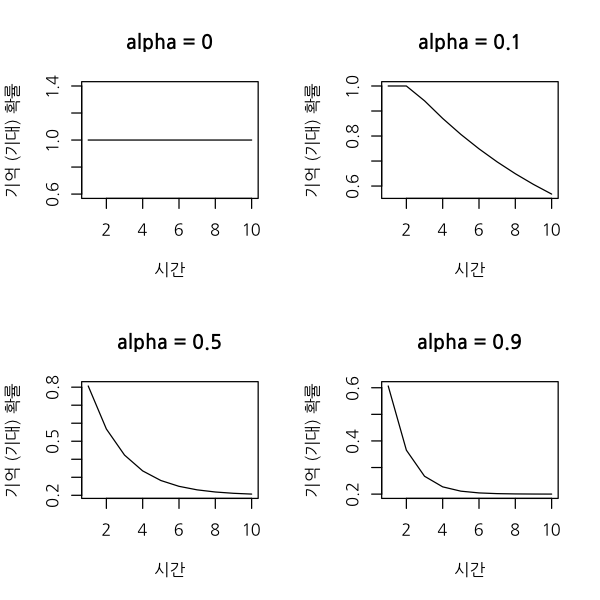

In [34]:
par(family = 'AppleGothic')
par(mfrow = c(2,2))

for (i in 1:nrow(res.df))
{
    res.df$res[[i]][res.df$res[[i]] > 1] = 1 ## 1 이상 1로
    plot(t.var, res.df$res[[i]], xlab = '시간', ylab = '기억 (기대) 확률', main = paste0('alpha = ', res.df$alpha[[i]]), type = 'l')
}

# 10.1 No individual differences

![fig10_1](images/fig10_1.png)

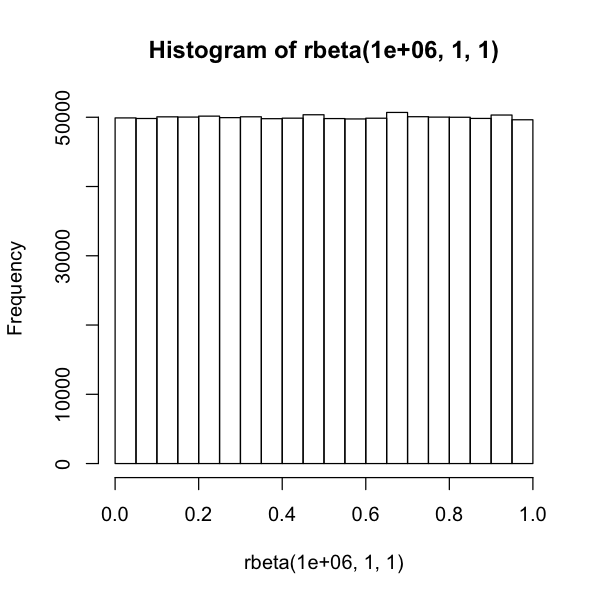

In [6]:
hist(rbeta(1000000,1,1))

In [7]:
suppressMessages(library(rstan))
#rstan_options(auto_write = TRUE)
#options(mc.cores = parallel::detectCores())

In [8]:
model <- "
// Retention With No Individual Differences
data { 
int ns;
int nt;
int k[ns - 1,nt - 1];
int t[nt];
int n;
}
parameters {
real<lower=0,upper=1> alpha;
real<lower=0,upper=1> beta;
} 
transformed parameters {
matrix<lower=0,upper=1>[ns,nt] theta;

// Retention Rate At Each Lag For Each Subject Decays Exponentially
for (i in 1:ns) {
for (j in 1:nt) {
theta[i,j] <- fmin(1, exp(-alpha * t[j]) + beta);
}
}
}
model {
// Priors
alpha ~ beta(1, 1);  // can be removed
beta ~ beta(1, 1);  // can be removed

// Observed Data
for (i in 1:(ns - 1))
for (j in 1:(nt - 1))
k[i,j] ~ binomial(n, theta[i,j]);
}
generated quantities {
int<lower=0,upper=n> predk[ns,nt];

// Predicted Data
for (i in 1:ns)
for (j in 1:nt)
predk[i,j] <- binomial_rng(n, theta[i,j]);
}"

In [9]:
## Data
t     <- c(1, 2, 4, 7, 12, 21, 35, 59, 99, 200)
nt    <- length(t)
slist <- 1:4
ns    <- length(slist)

k1 <- matrix(c(18, 18, 16, 13, 9, 6, 4, 4, 4, NA,
               17, 13,  9,  6, 4, 4, 4, 4, 4, NA,
               14, 10,  6,  4, 4, 4, 4, 4, 4, NA,
               NA, NA, NA, NA,NA,NA,NA,NA,NA, NA), nrow=ns, ncol=nt, byrow=T)

k <- k1[1:(ns - 1), 1:(nt - 1)]   # Excluding NAs (for Stan solution)

n <- 18

data <- list(k=k, n=n, t=t, ns=ns, nt=nt) # To be passed on to Stan

In [10]:
data

18,18,16,13,9,6,4,4,4
17,13,9,6,4,4,4,4,4
14,10,6,4,4,4,4,4,4


In [11]:
myinits <- list(
    list(alpha=.5, beta=.1))

parameters <- c("alpha", "beta", "predk")  # Parameters to be monitored

In [12]:
samples <- stan(model_code=model,   
                data=data, 
                init=myinits,  # If not specified, gives random inits
                pars=parameters,
                iter=20000, 
                chains=1, 
                thin=5,
                warmup = 5000,  # Stands for burn-in; Default = iter/2
                seed = 12345  # Setting seed; Default is random seed
)


SAMPLING FOR MODEL '7d2b1c02fbf3ff8ebac7c6b5ce5600a1' NOW (CHAIN 1).

Chain 1, Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1, Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1, Iteration:  4000 / 20000 [ 20%]  (Warmup)
Chain 1, Iteration:  5001 / 20000 [ 25%]  (Sampling)
Chain 1, Iteration:  7000 / 20000 [ 35%]  (Sampling)
Chain 1, Iteration:  9000 / 20000 [ 45%]  (Sampling)
Chain 1, Iteration: 11000 / 20000 [ 55%]  (Sampling)
Chain 1, Iteration: 13000 / 20000 [ 65%]  (Sampling)
Chain 1, Iteration: 15000 / 20000 [ 75%]  (Sampling)
Chain 1, Iteration: 17000 / 20000 [ 85%]  (Sampling)
Chain 1, Iteration: 19000 / 20000 [ 95%]  (Sampling)
Chain 1, Iteration: 20000 / 20000 [100%]  (Sampling)
#  Elapsed Time: 0.290048 seconds (Warm-up)
#                1.04542 seconds (Sampling)
#                1.33547 seconds (Total)



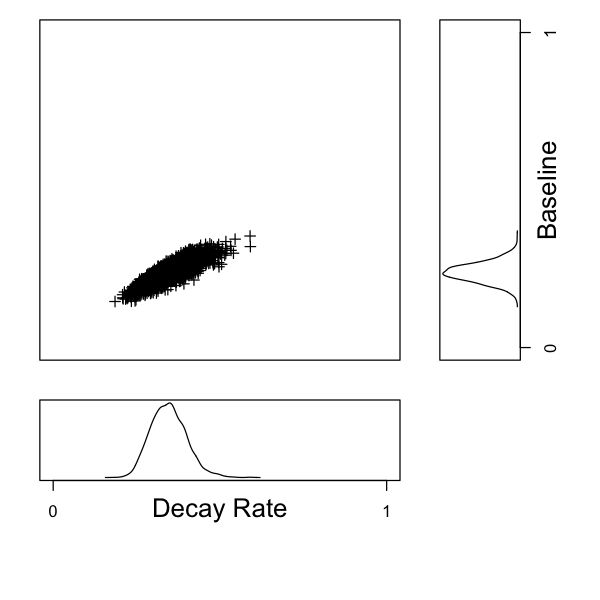

In [13]:
##Figure 10.2

alpha <- extract(samples)$alpha
beta <- extract(samples)$beta
d.beta <- density(beta)

layout(matrix(c(1,2,3,0),2,2,byrow=T), width=c(2/3, 1/3), heights=c(2/3,1/3))
#layout.show()

par(mar=c(2,2,1,0))
plot(alpha,beta, xlab="", ylab="", pch = 3, xlim=c(0,1),ylim=c(0,1),axes=F)
box(lty=1)

par(mar=c(2,2,1,4))
plot(d.beta$y, d.beta$x, ylim=range(c(0,1)), xlim=rev(range(d.beta$y)), 
     type='l', axes=F, xlab="", ylab="")
axis(4, at=c(0,1))
mtext('Baseline', side=4,line=1, cex=1.3)
box(lty=1)

par(mar=c(6,2,0,0))
plot(density(alpha),zero.line=F, main="", ylab="", xlab="", cex.lab=1.3,
     xlim=c(0,1), axes=F)
axis(1,at=c(0,1))
mtext('Decay Rate', side=1.2,line=1, cex=1.3)
box(lty=1)

The marginals show the distribution of each parameter, condi- tioned on the data, considered independently of the other parameter (i.e., averaged across the other parameter).
It is clear from Figure 10.2 that the joint posterior carries more information than the two marginal distributions. If the joint posterior were independent, it would be just the product of the two marginals. But the joint posterior shows a mild relationship, with larger values of α generally corresponding to larger values of β.

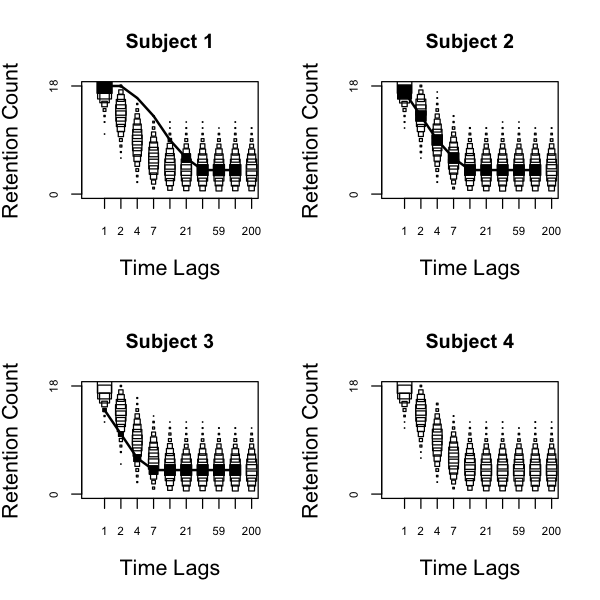

In [14]:
##Figure 10.3

layout(matrix(c(1:4),2,2,byrow=T))
#layout.show()
sc <- 3.5
jj <- numeric()
xx <- numeric()

for (i in 1:ns) 
{
    plot(-1,100,xlim=c(0,10),ylim=c(0,18), main=(paste("Subject", i)),
         xlab=("Time Lags"), ylab=("Retention Count"),cex.lab=1.3, axes=F)
    axis(1, at=c(1,2,3,4,5,6,7,8,9,10), 
         lab=c("1","2","4","7","12","21","35","59","99","200"),cex.axis=0.7)
    axis(2, at=c(0,18),lab=c("0","18"),cex.axis=0.7)
    box(lty=1)
    for (j in 1:nt) 
    {
        count <- hist(extract(samples)$predk[,i,j],c(0:n),plot=F)
        count <- count$counts
        count <- count/sum(count)
        for (x in 1:n)
        {
            if (count[x]>0)
            {
                points(j,x,pch=22, col="black",cex=sc*sqrt(count[x]))
                if (!is.na(k1[i,j]) && k1[i,j]==x)
                {
                    points(j,x,pch=22,bg="black",cex=sc*sqrt(count[x]))
                    jj <- c(jj,j)
                    xx <- c(xx,x)
                }
            }
        }
    }
    coords <- list(x=jj, y=xx)
    lines(coords,lwd=2)
    jj <- numeric()
    xx <- numeric()
}

## 요약
fig10.2 -> slope(Decay Rate)와 intercept(Baseline)는 상관있음  
fig10.3 -> 모형(개인차 X)과 실제 개인 비교  
결론 : we can conclude that the modeling assumption of no individual differences is inappropriate.

### 개인차 반영
![fig10_4](images/fig10_4.png)

### 개인차 미반영![fig10_1](images/fig10_1.png)

In [15]:
model <- "
// Retention With Full Individual Differences
data { 
  int ns;
  int nt;
  int k[ns - 1,nt - 1];  // excluding missing values
  int t[nt];
  int n;
}
parameters {
  vector<lower=0,upper=1>[ns] alpha;
  //vector<lower=0.2,upper=1>[ns] beta;
  vector<lower=0,upper=1>[ns] beta;
} 
transformed parameters {
  matrix<lower=0,upper=1>[ns,nt] theta;

  // Retention Rate At Each Lag For Each Subject Decays Exponentially
  for (i in 1:ns)
    for (j in 1:nt)
          theta[i,j] <- fmin(1.0, exp(-alpha[i] * t[j]) + beta[i]); // inv_logit(exp(-alpha[i] * t[j]) + beta[i]);
}
model {
  // Priors
  alpha ~ beta(1, 1);  // can be removed
  //beta ~ beta(1, 1);  // can be removed
  
  // Observed Data
  for (i in 1:(ns - 1))
    for (j in 1:(nt - 1))
      k[i,j] ~ binomial(n, theta[i,j]);
}
generated quantities {
  int<lower=0,upper=n> predk[ns,nt];
  
  // Predicted Data
  for (i in 1:ns)
    for (j in 1:nt)
      predk[i,j] <- binomial_rng(n, theta[i,j]);
}"

In [16]:
myinits <- list(
  list(alpha=rep(.5, ns), beta=rep(.3, ns)))

In [17]:
samples <- stan(model_code=model,   
                data=data, 
                init=myinits,  # If not specified, gives random inits
                pars=parameters,
                iter=20000, 
                chains=1, 
                thin=1,
                ##warmup = 10000,  # Stands for burn-in; Default = iter/2
                seed = 12345 # Setting seed; Default is random seed
)


SAMPLING FOR MODEL '1a5d9117658060bc1188306a49568e9c' NOW (CHAIN 1).

Chain 1, Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1, Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1, Iteration:  4000 / 20000 [ 20%]  (Warmup)
Chain 1, Iteration:  6000 / 20000 [ 30%]  (Warmup)
Chain 1, Iteration:  8000 / 20000 [ 40%]  (Warmup)
Chain 1, Iteration: 10000 / 20000 [ 50%]  (Warmup)
Chain 1, Iteration: 10001 / 20000 [ 50%]  (Sampling)
Chain 1, Iteration: 12000 / 20000 [ 60%]  (Sampling)
Chain 1, Iteration: 14000 / 20000 [ 70%]  (Sampling)
Chain 1, Iteration: 16000 / 20000 [ 80%]  (Sampling)
Chain 1, Iteration: 18000 / 20000 [ 90%]  (Sampling)
Chain 1, Iteration: 20000 / 20000 [100%]  (Sampling)
#  Elapsed Time: 1.77978 seconds (Warm-up)
#                8.35918 seconds (Sampling)
#                10.139 seconds (Total)



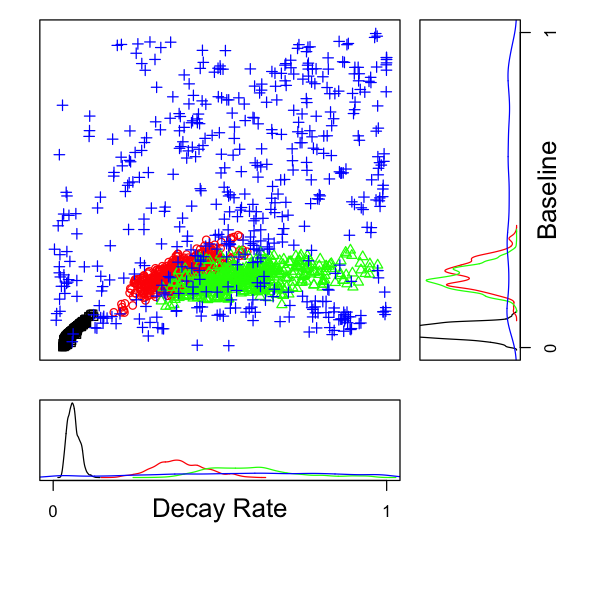

In [18]:
##Figure 10.5
n.iter <- 10000
keepi <- 500
keep <- sample(n.iter, keepi)

alpha1 <- extract(samples)$alpha[, 1]
alpha2 <- extract(samples)$alpha[, 2]
alpha3 <- extract(samples)$alpha[, 3]
alpha4 <- extract(samples)$alpha[, 4]

beta1 <- extract(samples)$beta[, 1]
beta2 <- extract(samples)$beta[, 2]
beta3 <- extract(samples)$beta[, 3]
beta4 <- extract(samples)$beta[, 4]
d.beta1 <- density(beta1)
d.beta2 <- density(beta2)
d.beta3 <- density(beta3)
d.beta4 <- density(beta4)

layout(matrix(c(1,2,3,0),2,2,byrow=T), width=c(2/3, 1/3), heights=c(2/3,1/3))
#layout.show()

par(mar=c(2,2,1,0))
plot(alpha1[keep],beta1[keep], xlab="", ylab="", xlim=c(0,1), ylim=c(0,1),
     axes=F, pch = 0)
points(alpha2[keep],beta2[keep], col="red", pch = 1)
points(alpha3[keep],beta3[keep], col="green", pch = 2)
points(alpha4[keep],beta4[keep], col="blue", pch = 3)
box(lty=1)

par(mar=c(2,1,1,4))
plot(d.beta1$y, d.beta1$x, ylim=range(c(0,1)), xlim=c(12,0),type='l', axes=F,
     xlab="", ylab="")
#plot(d.beta1$y, d.beta1$x, ylim=range(c(0,1)), xlim=rev(range(d.beta1$y)),
#     type='l', axes=F, xlab="", ylab="")
lines(d.beta2$y, d.beta2$x, col="red")
lines(d.beta3$y, d.beta3$x, col="green")
lines(d.beta4$y, d.beta4$x, col="blue")
axis(4, at=c(0,1))
mtext('Baseline', side=4,line=1, cex=1.3)
box(lty=1)

par(mar=c(6,2,0,0))
plot(density(alpha1),zero.line=F ,main="", ylab="", xlab="", cex.lab=1.3,
     xlim=c(0,1), axes=F)
lines(density(alpha2), col="red")
lines(density(alpha3), col="green")
lines(density(alpha4),col="blue")
axis(1,at=c(0,1))
mtext('Decay Rate', side=1.2,line=1, cex=1.3)
box(lty=1)

The first, second, third, and fourth subjects use square, circular, triangular, and cross markers, respectively. The marginal distributions are shown below and to the right, and use different line styles to represent the subjects.

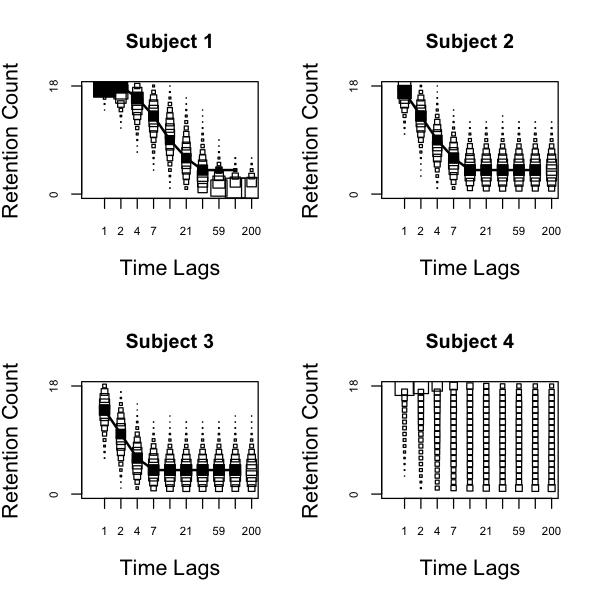

In [19]:
##Figure 10.6
#close previous graph window before running this code

layout(matrix(c(1:4),2,2,byrow=T))
#layout.show()
sc <- 3.5
jj <- numeric()
xx <- numeric()

for (i in 1:ns) {
    plot(-1,100,xlim=c(0,10),ylim=c(0,18), main=(paste("Subject", i)),
         xlab=("Time Lags"), ylab=("Retention Count"),cex.lab=1.3, axes=F)
    axis(1, at=c(1,2,3,4,5,6,7,8,9,10), cex.axis=0.7,
         lab=c("1","2","4","7","12","21","35","59","99","200"))
    axis(2, at=c(0,18),lab=c("0","18"),cex.axis=0.7)
    box(lty=1)
    for (j in 1:nt) {
        count <- hist(extract(samples)$predk[,i,j],c(0:n),plot=F)
        count <- count$counts
        count <- count/sum(count)
        for (x in 1:n){
            if (count[x]>0){
                points(j,x,pch=22, col="black",cex=sc*sqrt(count[x]))
                if (!is.na(k1[i,j]) && k1[i,j]==x){
                    points(j,x,pch=22,bg="black",cex=sc*sqrt(count[x]))
                    jj <- c(jj,j)
                    xx <- c(xx,x)
                }
            }
        }
    }
    coords <- list(x=jj, y=xx)
    lines(coords,lwd=2)
    jj <- numeric()
    xx <- numeric()
}

## Aggregation Vs Individual Differences

메모리 문제 뿐만 아니라 모든 분야에 해당  
예) 대출 / 보험 / 구매 / 광고 등

## Problem
The <b> weakness </b> in the current model is evident in its predictions for Subject 4. Because each subject is assumed to have decay and baseline parameters that are different, the only information the model has about the new subject is the priors for the α and β parameters. The relationships between parameters for subjects that are visually evident in Figure 10.5 are not formally captured by the model.   

In this way, the model fails a basic test of <b> generalizability </b>, since it does not make sensible predictions for the behavior of subjects other than those for whom data are available.

# 10.3 Structured individual differences

![fig10_7](images/fig10_7.png)

![fig10_4](images/fig10_4.png)

The key change is that now the αi and βi parameters for each subject are modeled as coming from Gaussian distributions. The over-arching Gaussian distribution models this <b> group-level structure for each parameter </b>. This group structure itself has parameters, in the form of means μα for the decay and μβ for the baseline, and precisions λα for the decay and λβ for the baseline. In this way, the individual differences between subjects are given structure.

Each αi and βi parameter is independently sampled, so they can be different, but they are sampled from the <b> same (each group) distribution </b>, so they have a relationship to one another. This means that inferences made for one subject influence predictions made for another. Since the means and precisions of the group-level distributions are common to all subjects, what is learned about them from one subject affects what is known about another. In addition, because they are sampled from over- arching distributions, the αi and βi parameters at the individual subject level no longer have <b> priors </b> explicitly specified, but inherit them from the priors on the means and precisions of the <b> group-level Gaussian distributions. </b>

In [20]:
model <- "
// Retention With Structured Individual Differences
data { 
  int ns;
  int nt;
  int k[ns - 1,nt - 1];
  int t[nt];
  int n;
}
parameters {
  vector<lower=0,upper=1>[ns] alpha;
//  vector<lower=0.2,upper=1>[ns] beta;
  vector<lower=0,upper=1>[ns] beta;
  real<lower=0,upper=1> alphamu;
  real<lower=0,upper=1> betamu;
  real<lower=.001> alphalambda;
  real<lower=.001> betalambda;
} 
transformed parameters {
  matrix<lower=0,upper=1>[ns,nt] theta;
  real<lower=0> alphasigma;
  real<lower=0> betasigma;
  
  alphasigma <- inv_sqrt(alphalambda);
  betasigma <- inv_sqrt(betalambda);
  
  // Retention Rate At Each Lag For Each Subject Decays Exponentially
  for (i in 1:ns)
    for (j in 1:nt)
      theta[i,j] <- fmin(1.0, exp(-alpha[i] * t[j]) + beta[i]);;
}
model {
  // Priors For Group Distributions
  alphamu ~ beta(1, 1);  // can be removed
  betamu ~ beta(1, 1);  // can be removed
  alphalambda ~ gamma(.001, .001)T[.001,];
  betalambda ~ gamma(.001, .001)T[.001,];
  // Parameters For Each Subject Drawn From Gaussian Group Distributions
  for (i in 1:ns)  {
    alpha[i] ~ normal(alphamu, alphasigma)T[0,1];
    beta[i] ~ normal(betamu, betasigma)T[0,1];
  }
  // Observed Data
  for (i in 1:(ns - 1))
    for (j in 1:(nt - 1))
      k[i,j] ~ binomial(n, theta[i,j]);
}
generated quantities {
  int<lower=0,upper=n> predk[ns,nt];
  
  // Predicted Data
  for (i in 1:ns)
    for (j in 1:nt)
      predk[i,j] <- binomial_rng(n, theta[i,j]);
}"

In [21]:
myinits <- list(
  list(alphamu=.5, alphalambda=1, betamu=.5, betalambda=1, 
     alpha=rep(.5, ns), beta=rep(.3, ns)))

In [22]:
samples <- stan(model_code=model,   
                data=data, 
                init=myinits,  # If not specified, gives random inits
                pars=parameters,
                iter=20000, 
                chains=1, 
                thin=5,
                warmup = 5000,  # Stands for burn-in; Default = iter/2
                seed = 12345  # Setting seed; Default is random seed
)


SAMPLING FOR MODEL 'f83706522e2270ed5c6fd13a4b264389' NOW (CHAIN 1).

Chain 1, Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1, Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1, Iteration:  4000 / 20000 [ 20%]  (Warmup)
Chain 1, Iteration:  5001 / 20000 [ 25%]  (Sampling)
Chain 1, Iteration:  7000 / 20000 [ 35%]  (Sampling)
Chain 1, Iteration:  9000 / 20000 [ 45%]  (Sampling)
Chain 1, Iteration: 11000 / 20000 [ 55%]  (Sampling)
Chain 1, Iteration: 13000 / 20000 [ 65%]  (Sampling)
Chain 1, Iteration: 15000 / 20000 [ 75%]  (Sampling)
Chain 1, Iteration: 17000 / 20000 [ 85%]  (Sampling)
Chain 1, Iteration: 19000 / 20000 [ 95%]  (Sampling)
Chain 1, Iteration: 20000 / 20000 [100%]  (Sampling)
#  Elapsed Time: 1.13374 seconds (Warm-up)
#                6.28576 seconds (Sampling)
#                7.4195 seconds (Total)



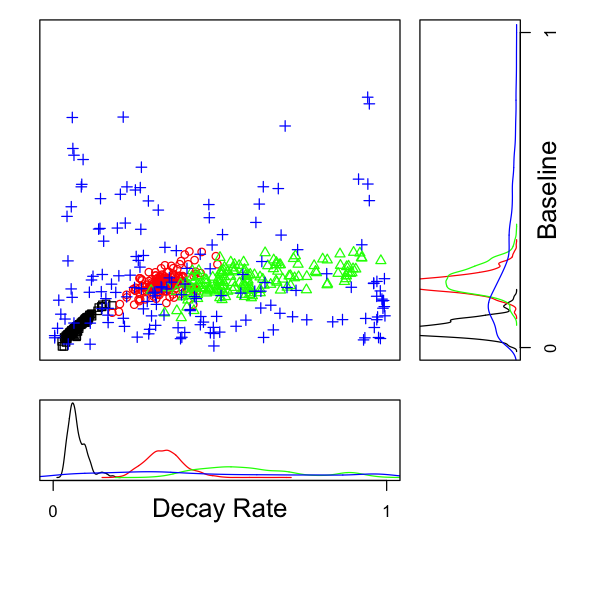

In [23]:
##Figure 10.8
n.iter <- 10000
keepi <- 500
keep <- sample(n.iter, keepi)

alpha1 <- extract(samples)$alpha[, 1]
alpha2 <- extract(samples)$alpha[, 2]
alpha3 <- extract(samples)$alpha[, 3]
alpha4 <- extract(samples)$alpha[, 4]

beta1 <- extract(samples)$beta[, 1]
beta2 <- extract(samples)$beta[, 2]
beta3 <- extract(samples)$beta[, 3]
beta4 <- extract(samples)$beta[, 4]
d.beta1 <- density(beta1)
d.beta2 <- density(beta2)
d.beta3 <- density(beta3)
d.beta4 <- density(beta4)

layout(matrix(c(1,2,3,0),2,2,byrow=T), width=c(2/3, 1/3), heights=c(2/3,1/3))
#layout.show()

par(mar=c(2,2,1,0))
plot(alpha1[keep],beta1[keep], xlab="", ylab="", xlim=c(0,1), ylim=c(0,1),
     axes=F, pch = 0)
points(alpha2[keep],beta2[keep], col="red", pch= 1)
points(alpha3[keep],beta3[keep], col="green", pch = 2)
points(alpha4[keep],beta4[keep], col="blue", pch = 3)
box(lty=1)

par(mar=c(2,1,1,4))
plot(d.beta1$y, d.beta1$x, ylim=range(c(0,1)), xlim=c(12,0),type='l', axes=F, 
     xlab="", ylab="")
#plot(d.beta1$y, d.beta1$x, ylim=range(c(0,1)), xlim=rev(range(d.beta1$y)),
#     type='l', axes=F, xlab="", ylab="")
lines(d.beta2$y, d.beta2$x, col="red")
lines(d.beta3$y, d.beta3$x, col="green")
lines(d.beta4$y, d.beta4$x, col="blue")
axis(4, at=c(0,1))
mtext('Baseline', side=4,line=1, cex=1.3)
box(lty=1)

par(mar=c(6,2,0,0))
plot(density(alpha1),zero.line=F ,main="", ylab="", xlab="", cex.lab=1.3,
     xlim=c(0,1), axes=F)
lines(density(alpha2), col="red")
lines(density(alpha3), col="green")
lines(density(alpha4),col="blue")
axis(1,at=c(0,1))
mtext('Decay Rate', side=1.2,line=1, cex=1.3)
box(lty=1)

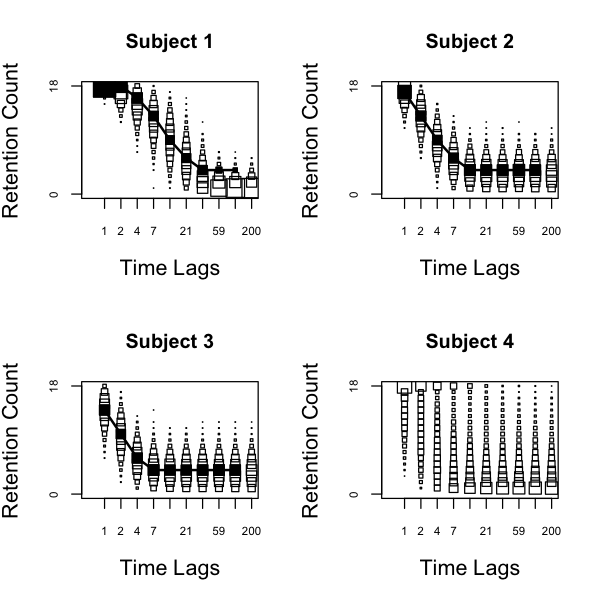

In [24]:
##Figure 10.9
#close previous graph window before running this code

layout(matrix(c(1:4),2,2,byrow=T))
#layout.show()
sc <- 3.5
jj <- numeric()
xx <- numeric()

for (i in 1:ns) {
    plot(-1,100,xlim=c(0,10),ylim=c(0,18), main=(paste("Subject", i)),
         xlab=("Time Lags"), ylab=("Retention Count"),cex.lab=1.3, axes=F)
    axis(1, at=c(1,2,3,4,5,6,7,8,9,10),cex.axis=0.7,
         lab=c("1","2","4","7","12","21","35","59","99","200"))
    axis(2, at=c(0,18),lab=c("0","18"),cex.axis=0.7)
    box(lty=1)
    for (j in 1:nt) {
        count <- hist(extract(samples)$predk[,i,j],c(0:n),plot=F)
        count <- count$counts
        count <- count/sum(count)
        for (x in 1:n){
            if (count[x]>0){
                points(j,x,pch=22, col="black",cex=sc*sqrt(count[x]))
                if (!is.na(k1[i,j]) && k1[i,j]==x){
                    points(j,x,pch=22,bg="black",cex=sc*sqrt(count[x]))
                    jj <- c(jj,j)
                    xx <- c(xx,x)
                }
            }
        }
    }
    coords <- list(x=jj, y=xx)
    lines(coords,lwd=2)
    jj <- numeric()
    xx <- numeric()
}